In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU tespit edildi ve Memory Growth aktif edildi.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU bulunamadı, CPU kullanılıyor.")

DATA_PATH = "datasets/CNN_ACC_SEV_V1.v2i.multiclass"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

✅ 1 GPU tespit edildi ve Memory Growth aktif edildi.


In [4]:
def load_data(subset):
    """
    Dataseti içeri aktarır.
    :param subset: (test,train,valid)
    :return: csv dataset
    """
    csv_path = os.path.join(DATA_PATH, subset, "_classes.csv")
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()  #sütun adlarındaki boşlukları temizle.

    #filename sütununu path'e çevirme
    df['filename'] = df['filename'].apply(lambda x: os.path.normpath(os.path.join(DATA_PATH, subset, x)))
    return df

In [9]:
def create_dataset(df):
    images = df["filename"].values
    labels = df[["moderate-accident", "no-accident", "severe-accident"]].values.astype(
        "float32")  #tf ile uyumlu olması için float32 tipine dönüştürülür.

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))  #tf dataset

    dataset = dataset.map(lambda x, y: (preprocess_image(x), y),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)  # ön işleme için lambda fonk ve performans opt(paralel işleme)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  #performans opt.
    return dataset


def preprocess_image(image_path):
    img = tf.io.read_file(image_path)  #imageleri byte formatında okur, henüz çözümleme yapılmadı
    img = tf.image.decode_jpeg(img, channels=3)  #resmi 3 kanallı tensöre çevrildi
    img = tf.image.resize(img, [224, 224])  #standart boyutlaştırma
    img = tf.cast(img, tf.float32)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [10]:
#Orjinal veriler
train_df = load_data("train")
valid_df = load_data("valid")
test_df = load_data("test")
print(f"{len(train_df)} train samples")
print(f"{len(valid_df)} validation samples")
print(f"{len(test_df)} test samples\n")

print(f"Ciddi Dereceli Kaza: {train_df['severe-accident'].sum()}")
print(f'Orta Dereceli Kaza: {train_df["moderate-accident"].sum()}')
print(f'Kaza Yok: {train_df["no-accident"].sum()}')

#Tensorflow Datasetler
train_df = create_dataset(train_df)
valid_df = create_dataset(valid_df)
test_df = create_dataset(test_df)

7452 train samples
712 validation samples
354 test samples

Ciddi Dereceli Kaza: 2382
Orta Dereceli Kaza: 2439
Kaza Yok: 2631


In [11]:
base_model = VGG19(
    include_top=False, # Son katmanı at
    weights="imagenet", # ImageNet ağırlıklarını getir
    input_shape=(224, 224, 3)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

x = GlobalAveragePooling2D()(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x) # Stabilizasyon
x = Dropout(0.5)(x) # Overfitting önleyici

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [13]:
# 1. Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2. Callbacks
my_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        "best_model_files/best_vgg19.weights.h5",
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )
]

In [14]:
history = model.fit(
    train_df,
    validation_data=valid_df,
    epochs=50,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/50
233/233 [==============================] - 111s 422ms/step - loss: 0.7492 - accuracy: 0.7006 - val_loss: 0.3879 - val_accuracy: 0.8427 - lr: 0.0010
Epoch 2/50
233/233 [==============================] - 85s 365ms/step - loss: 0.4149 - accuracy: 0.8268 - val_loss: 0.2645 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 3/50
233/233 [==============================] - 85s 363ms/step - loss: 0.3198 - accuracy: 0.8686 - val_loss: 0.2257 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 4/50
233/233 [==============================] - 84s 363ms/step - loss: 0.2744 - accuracy: 0.8930 - val_loss: 0.1826 - val_accuracy: 0.9494 - lr: 0.0010
Epoch 5/50
233/233 [==============================] - 85s 363ms/step - loss: 0.2382 - accuracy: 0.9082 - val_loss: 0.1718 - val_accuracy: 0.9508 - lr: 0.0010
Epoch 6/50
233/233 [==============================] - 84s 362ms/step - loss: 0.2290 - accuracy: 0.9133 - val_loss: 0.1822 - val_accuracy: 0.9326 - lr: 0.0010
Epoch 7/50
233/233 [==============================]

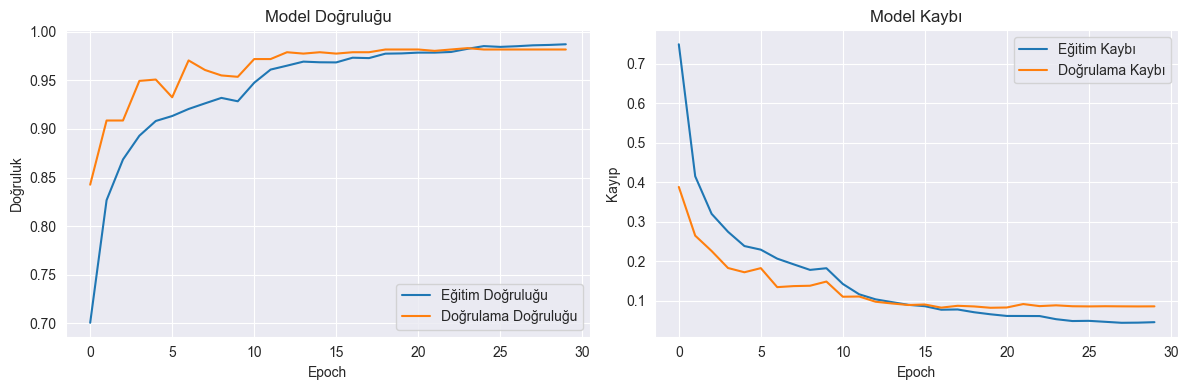

In [15]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Greafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.9802
F1 Score: 0.9802
ROC-AUC Score: 0.9990


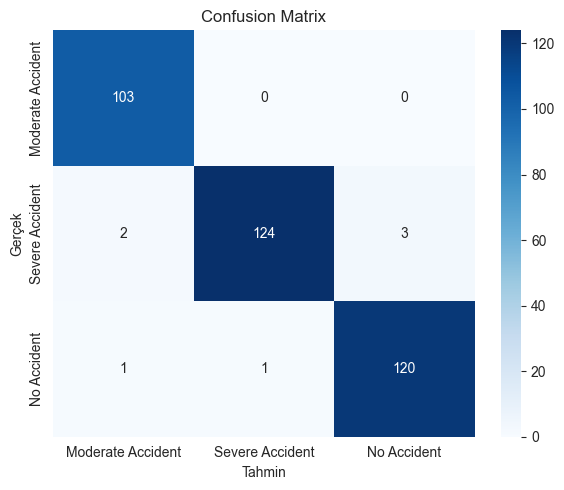


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.97      1.00      0.99       103
  Severe Accident       0.99      0.96      0.98       129
      No Accident       0.98      0.98      0.98       122

         accuracy                           0.98       354
        macro avg       0.98      0.98      0.98       354
     weighted avg       0.98      0.98      0.98       354



In [16]:
y_true = []
y_pred = []
y_proba = []

class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']

for images, labels in test_df:
    probs = model.predict(images, verbose =0)#verbose ile çıktı gösterilmez.
    preds = np.argmax(probs, axis=1)
    trues = np.argmax(labels.numpy(), axis=1)

    y_proba.extend(probs)
    y_true.extend(trues)
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_proba = np.array(y_proba)

acc = accuracy_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred, average='weighted')
roc_auc = roc_auc_score(tf.one_hot(y_true, len(class_names)), y_proba, multi_class='ovr')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Her sınıf için detaylı metrikler
print("\nSınıf Bazlı Performans:")
print(classification_report(y_true, y_pred, target_names=class_names))